In [0]:
!pip install azureml.train.automl
!pip install azure.cli

     |████████████████████████████████| 133kB 3.5MB/s 
     |████████████████████████████████| 5.4MB 10.8MB/s 
     |████████████████████████████████| 26.9MB 1.6MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 378kB 43.8MB/s 
     |████████████████████████████████| 2.0MB 29.9MB/s 
     |████████████████████████████████| 31.2MB 48.8MB/s 
     |████████████████████████████████| 1.2MB 38.0MB/s 
     |████████████████████████████████| 17.3MB 19.1MB/s 
     |████████████████████████████████| 122kB 48.1MB/s 
     |████████████████████████████████| 8.9MB 33.4MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 266kB 44.5MB/s 
     |████████████████████████████████| 4.8MB 27.0MB/s 
     |████████████████████████████████| 29.3MB 33.5MB/s 
     |████████████████████████████████| 1.3MB 27.8MB/s 
     |████████████████████████████████| 11.6MB 27.6MB/s 
     |████████████████████████████████| 61kB 8.2M

     |████████████████████████████████| 1.4MB 3.4MB/s 
     |████████████████████████████████| 184kB 43.2MB/s 
     |████████████████████████████████| 81kB 9.9MB/s 
     |████████████████████████████████| 348kB 39.5MB/s 
     |████████████████████████████████| 81kB 1.2MB/s 
     |████████████████████████████████| 112kB 45.1MB/s 
     |████████████████████████████████| 122kB 23.8MB/s 
     |████████████████████████████████| 1.2MB 38.9MB/s 
     |████████████████████████████████| 614kB 30.0MB/s 
     |████████████████████████████████| 143kB 40.2MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 143kB 49.7MB/s 
     |████████████████████████████████| 450kB 44.2MB/s 
     |████████████████████████████████| 1.2MB 31.2MB/s 
     |████████████████████████████████| 440kB 46.7MB/s 
     |████████████████████████████████| 890kB 25.0MB/s 
     |████████████████████████████████| 92kB 11.5MB/s 
     |████████████████████████████████| 143kB 49.9MB/s 


In [0]:
import azureml.core
#
print("This notebook was created using version 1.0.57 of the Azure ML SDK")
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK")

This notebook was created using version 1.0.57 of the Azure ML SDK
You are currently using version 1.0.74 of the Azure ML SDK


In [0]:
import logging

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from azureml.core import Workspace

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
from azureml.core.runconfig import RunConfiguration
from azureml.core.conda_dependencies import CondaDependencies

In [0]:
#ws = Workspace.from_config()
#!pip install azure.cli
from azureml.core.authentication import AzureCliAuthentication
import azure.cli.core
#cli_auth = AzureCliAuthentication()

ws = Workspace(subscription_id="24075937-2687-4457-bac6-ec16dec514c3",
               resource_group="VstsRG-784AbhijitC-8a31",
               workspace_name="automldc")

print("Found workspace {} at location {}".format(ws.name, ws.location))

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code EG8SA3X5X to authenticate.
Interactive authentication successfully completed.
Found workspace automldc at location centralus


In [0]:
#ws = Workspace.from_config()

# Choose a name for the experiment and specify the project folder.
experiment_name = 'Capstone_Project1'
project_folder = 'D:\\Stock_Prediction\\AutoML_Azure\\Python_AutoML'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

SDK version        1.0.74                                        
Subscription ID    24075937-2687-4457-bac6-ec16dec514c3          
Workspace Name     automldc                                      
Resource Group     VstsRG-784AbhijitC-8a31                       
Location           centralus                                     
Project Directory  D:\Stock_Prediction\AutoML_Azure\Python_AutoML
Experiment Name    Capstone_Project1

In [0]:
# Choose a name for your cluster.
amlcompute_cluster_name = "cpu-cluster"

found = False
# Check if this compute target already exists in the workspace.
cts = ws.compute_targets
if amlcompute_cluster_name in cts and cts[amlcompute_cluster_name].type == 'AmlCompute':
    found = True
    print('Found existing compute target.')
    compute_target = cts[amlcompute_cluster_name]
    
if not found:
    print('Creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = "Standard_F8s_v2", # for GPU, use "STANDARD_NC6"
                                                                #vm_priority = 'lowpriority', # optional
                                                                min_nodes=2,
                                                                max_nodes = 4)

    # Create the cluster.
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, provisioning_config)
    
    # Can poll for a minimum number of nodes and for a specific timeout.
    # If no min_node_count is provided, it will use the scale settings for the cluster.
    compute_target.wait_for_completion(show_output = True, min_node_count = 1, timeout_in_minutes = 10)
    
     # For a more detailed view of current AmlCompute status, use get_status().

Found existing compute target.


In [0]:
# create a new RunConfig object
conda_run_config = RunConfiguration(framework="python")

conda_run_config.environment.docker.enabled = True
conda_run_config.environment.docker.base_image = azureml.core.runconfig.DEFAULT_CPU_IMAGE

cd = CondaDependencies.create(pip_packages=['azureml-sdk[automl]'], 
                              conda_packages=['numpy', 'py-xgboost<=0.80'])
conda_run_config.environment.python.conda_dependencies = cd

print('run config is ready')

run config is ready


In [0]:
# Get a dataset by name
from azureml.core.dataset import Dataset

file_name = '2018Q4PredictionTrainedSet101.csv'
stock_dataset = Dataset.get_by_name(ws, '2018Q4PredictionTrainedSet101.csv')
#stock_dataset
#dataset = Dataset.Tabular.from_delimited_files(stock_dataset)
stock_dataset.to_pandas_dataframe().describe()
stock_dataset.take(3).to_pandas_dataframe()

X = stock_dataset.drop_columns(columns=[ 'ActionTaken'])
y = stock_dataset.keep_columns(columns=['ActionTaken'], validate=True)
print(y)
#print('X and y are ready!')
stock_dataset_df = stock_dataset.to_pandas_dataframe()
y_df = stock_dataset_df['ActionTaken'].values
x_df = stock_dataset_df.drop(['ActionTaken'], axis=1)
#print(y_df)

TabularDataset
{
  "source": [
    "('workspaceblobstore', '2018Q4PredictionTrainedSet101.csv')"
  ],
  "definition": [
    "GetDatastoreFiles",
    "ParseDelimited",
    "DropColumns",
    "SetColumnTypes",
    "KeepColumns"
  ]
}


In [0]:
import logging
import os
import time
from azureml.train.automl import AutoMLConfig
#azureml._restclient.snapshots_client.SNAPSHOT_MAX_SIZE_BYTES = '500'
automl_settings = {
                "name": "Myexp211",
                "iteration_timeout_minutes": 5,
                "iterations": 10,
                "n_cross_validations": 5,
                "primary_metric": "accuracy",
                "preprocess": True,
                "max_concurrent_iterations": 8,
                "verbosity": logging.INFO
            }
automl_config = AutoMLConfig(task="classification",
                                #debug_log='D:\Stock_Prediction\AutoML_Azure\Python_AutoML\automl_errors.log',
                                #path='D:\Stock_Prediction\AutoML_Azure\Python_AutoML',
                                compute_target=compute_target,
                                run_configuration=conda_run_config,
                                X=X,
                                y=y,
                                #data_script = project_folder + "\\get_data.py",
                                **automl_settings,
                                    )
print("AutoML config created.")
experiment=Experiment(ws, 'Myexp2_v1_test211')
remote_run = experiment.submit(automl_config, show_output=True)

WARNING - The AutoMLConfig inputs you have specified will soon be deprecated. Please use the AutoMLConfig shown in our documentation: https://aka.ms/AutoMLConfig


AutoML config created.
Running on remote or ADB.
Running on remote compute: cpu-cluster
Parent Run ID: AutoML_0a602ab3-0d42-46f7-b29c-c223fd3fe88d


ERROR: Setup iteration failed: Unidentified error, check logs in portal / compute


In [0]:
children = list(remote_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(axis=1, by='accuracy')
rundata
rundata.rename(columns = {0: "one", 1: "two",2: "three",3: "four",4: "five",5: "six",6: "seven",
                                    7: "right",8: "nine",9: "ten",}, inplace = True) 
rundata_toJson = rundata.to_json(orient='columns')
print(rundata_toJson)

lookup_metric = "accuracy"
best_run, fitted_model = remote_run.get_output(metric = lookup_metric)
best_run_details = best_run.get_metrics()
df = pd.DataFrame.from_dict(best_run_details, orient='index')
df.rename(columns = {0: "Best Matrics"}, inplace = True)
df_json = df.to_json(orient='columns')
print(df_json)
#result = rundata_toJson.update(df_json)

#print(result)
dict = {}
dict[rundata_toJson] = rundata_toJson
dict[df_json] = df_json
#dict['best_run_id'] = best_run_id
print(dict)

NameError: ignored

In [0]:
df = pd.DataFrame.from_dict(best_run_details, orient='index')
df.rename(columns = {0: "Best Matrics"}, inplace = True)
df_json = df.to_json(orient='columns')
df.rename(columns = {0: "Best_Matrics"}, inplace = True)
rundata.rename(columns = {0: "Best_Matrics"}, inplace = True) 
print(df_json)

{"Best Matrics":{"AUC_weighted":0.6537974029,"recall_score_micro":0.5393463539,"f1_score_weighted":0.5091701197,"norm_macro_recall":0.2353401052,"precision_score_weighted":0.5390684293,"f1_score_macro":0.4869062502,"AUC_macro":0.7012453297,"balanced_accuracy":0.4902267368,"precision_score_micro":0.5393463539,"confusion_matrix":"aml:\/\/artifactId\/ExperimentRun\/dcid.AutoML_1ba6c06d-1e71-4fb6-a35a-f01a1c6dc58b_8\/confusion_matrix","average_precision_score_weighted":0.5536560928,"precision_score_macro":0.5370106432,"average_precision_score_micro":0.5623914853,"accuracy_table":"aml:\/\/artifactId\/ExperimentRun\/dcid.AutoML_1ba6c06d-1e71-4fb6-a35a-f01a1c6dc58b_8\/accuracy_table","recall_score_macro":0.4902267368,"average_precision_score_macro":0.5252046224,"AUC_micro":0.7593457498,"log_loss":0.8917354627,"weighted_accuracy":0.5762853699,"accuracy":0.5393463539,"f1_score_micro":0.5393463539,"recall_score_weighted":0.5393463539}}


In [0]:
lookup_metric = "accuracy"
best_run, fitted_model = remote_run.get_output(metric = lookup_metric)
#print(best_run.get_metrics())
print(fitted_model)
#best_run.id
#fitted_model

Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, is_cross_validation=None,
        is_onnx_compatible=None, logger=None, observer=None, task=None)), ('pref...))],
               flatten_transform=None,
               weights=[0.1, 0.3, 0.3, 0.1, 0.1, 0.1]))])
Y_transformer(['LabelEncoder', LabelEncoder()])


In [0]:
description = 'AutoML Model'
model_name = 'my_model'
tags = None
model = remote_run.register_model(model_name = model_name, description = description, tags = tags)
print(model.name, model.id, model.version, sep='\t')
remote_run.model_id # This will be written to the scoring script file later in the notebook.

my_model	my_model:1	1


'my_model'

In [0]:
from azureml.core.model import Model
model = Model(ws, name="my_model")
print(model)
model.download()
#model = Model(self,)
#model = Model(ws, run_id='AutoML_e0074e6e-e84e-4f46-bdeb-b14792351d6b_8')

Model(workspace=Workspace.create(name='automldc', subscription_id='24075937-2687-4457-bac6-ec16dec514c3', resource_group='VstsRG-784AbhijitC-8a31'), name=my_model, id=my_model:1, version=1, tags={}, properties={})


'model.pkl'

In [0]:
from azureml.core import Run
from sklearn.externals import joblib
experiment=Experiment(ws, 'Myexp2_v1_test21')
#run = experiment.workspace_object

best_run = Run(experiment=experiment, run_id='AutoML_e0074e6e-e84e-4f46-bdeb-b14792351d6b_8')
#fitted_model = Run(experiment=experiment, run_id='AutoML_e0074e6e-e84e-4f46-bdeb-b14792351d6b_8')
print(best_run.get_file_names())
#Best_model = best_run.get_file_names('model.pkl')
model = joblib.load('model.pkl')
print(model)
pred = model.predict(x_df)
#pred_df = as.data.frame(pred)
print(pred)


['accuracy_table', 'automl_driver.py', 'azureml-logs/55_azureml-execution-tvmps_fa4b544c3af8ebb0e313a2724bf2232dce510c11430fd87574abac926ac1ae33_d.txt', 'azureml-logs/65_job_prep-tvmps_fa4b544c3af8ebb0e313a2724bf2232dce510c11430fd87574abac926ac1ae33_d.txt', 'azureml-logs/70_driver_log.txt', 'azureml-logs/75_job_post-tvmps_fa4b544c3af8ebb0e313a2724bf2232dce510c11430fd87574abac926ac1ae33_d.txt', 'azureml-logs/process_info.json', 'azureml-logs/process_status.json', 'confusion_matrix', 'logs/azureml/154_azureml.log', 'logs/azureml/azureml.log', 'logs/azureml/azureml_automl.log', 'outputs/conda_env_v_1_0_0.yml', 'outputs/env_dependencies.json', 'outputs/model.pkl', 'outputs/scoring_file_v_1_0_0.py', 'pipeline_graph.json']
Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, is_cross_validation=None,
        is_onnx_compatible

In [0]:
df = pd.DataFrame(pred)
df.rename(columns = {0: "Prediction"}, inplace = True) 
stock_df = stock_dataset_df[['fund_id','stock_id','ActionTaken']]
result = pd.concat([stock_df,df],axis=1)
result.head()
json = result.to_json(orient='records')
json

'[{"fund_id":189,"stock_id":1,"ActionTaken":"Increasing","Prediction":"Decreasing"},{"fund_id":26,"stock_id":1,"ActionTaken":"Decreasing","Prediction":"Decreasing"},{"fund_id":26,"stock_id":1,"ActionTaken":"Decreasing","Prediction":"Hold"},{"fund_id":245,"stock_id":4,"ActionTaken":"Decreasing","Prediction":"Decreasing"},{"fund_id":245,"stock_id":4,"ActionTaken":"Decreasing","Prediction":"Decreasing"},{"fund_id":245,"stock_id":4,"ActionTaken":"Increasing","Prediction":"Decreasing"},{"fund_id":245,"stock_id":4,"ActionTaken":"Decreasing","Prediction":"Decreasing"},{"fund_id":129,"stock_id":1,"ActionTaken":"Decreasing","Prediction":"Decreasing"},{"fund_id":129,"stock_id":1,"ActionTaken":"Decreasing","Prediction":"Decreasing"},{"fund_id":129,"stock_id":1,"ActionTaken":"Increasing","Prediction":"Decreasing"},{"fund_id":129,"stock_id":1,"ActionTaken":"Decreasing","Prediction":"Decreasing"},{"fund_id":129,"stock_id":1,"ActionTaken":"Decreasing","Prediction":"Decreasing"},{"fund_id":129,"stock_

In [0]:
list_experiments = Experiment.list(ws)
list_experiments

[Experiment(Name: Capstone_Project1,
 Workspace: automldc), Experiment(Name: Myexp2_v1_test1,
 Workspace: automldc), Experiment(Name: AutoML_Demo_Experiment_from_API_v5,
 Workspace: automldc), Experiment(Name: AutoML_Demo_Experiment_from_API_v6,
 Workspace: automldc), Experiment(Name: Myexp2_v1_test2,
 Workspace: automldc), Experiment(Name: AutoML_Demo_Experiment_from_API_v8,
 Workspace: automldc), Experiment(Name: automldc,
 Workspace: automldc)]

In [0]:
from azureml.train.automl import AutoMLStep

trainWithAutomlStep = AutoMLStep(
    name='AutoML_Classification',
    automl_config=automl_config,
    outputs=[metirics_data, model_data],
    allow_reuse=True)

print("trainWithAutomlStep created.")

trainWithAutomlStep created.


In [0]:
from azureml.pipeline.core import Pipeline
from azureml.widgets import RunDetails

pipeline_steps = [trainWithAutomlStep]

pipeline = Pipeline(workspace = ws, steps=pipeline_steps)
print("Pipeline is built.")

pipeline_run = experiment.submit(pipeline, regenerate_outputs=True)
RunDetails(pipeline_run).show()
# Before we proceed we need to wait for the run to complete.
pipeline_run.wait_for_completion()
print("Pipeline submitted for execution.")


Pipeline is built.


TypeError: ignored

In [0]:
RunDetails(pipeline_run).show()
# Before we proceed we need to wait for the run to complete.
pipeline_run.wait_for_completion()



KeyboardInterrupt: ignored

In [0]:
pipeline_run = experiment.submit(pipeline)

#from azureml.widgets import RunDetails
#RunDetails(pipeline_run).show()

#pipeline_run.wait_for_completion()

Submitted PipelineRun c4775eb7-bee5-4fb6-b15b-ace9e130e398
Link to Azure Machine Learning studio: https://ml.azure.com/experiments/Myexp2_v1_test1/runs/c4775eb7-bee5-4fb6-b15b-ace9e130e398?wsid=/subscriptions/24075937-2687-4457-bac6-ec16dec514c3/resourcegroups/VstsRG-784AbhijitC-8a31/workspaces/demoautoml


In [0]:
print(remote_run)
from azureml.widgets import RunDetails
RunDetails(remote_run).show()

Run(Experiment: Myexp2_v1_test1,
Id: AutoML_c123e920-9f32-4391-8056-1219db0e49c0,
Type: automl,
Status: Running)


ModuleNotFoundError: ignored

In [0]:
best_run, fitted_model = remote_run.get_output()
print(best_run)
print(fitted_model)

Run(Experiment: Myexp2_v1_test1,
Id: AutoML_c123e920-9f32-4391-8056-1219db0e49c0_9,
Type: azureml.scriptrun,
Status: Completed)
Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, is_cross_validation=None,
        is_onnx_compatible=None, logger=None, observer=None, task=None)), ('stac...7efbdd2fd898>,
           solver='lbfgs', tol=0.0001, verbose=0),
            training_cv_folds=5))])
Y_transformer(['LabelEncoder', LabelEncoder()])


In [0]:
print(best_run.get_file_names())

['accuracy_table', 'confusion_matrix', 'outputs/conda_env_v_1_0_0.yml', 'outputs/env_dependencies.json', 'outputs/model.pkl', 'outputs/scoring_file_v_1_0_0.py', 'pipeline_graph.json']


In [0]:
run_latest = list(experiment.get_runs())[0] # get_runs returns generator, natural way in python is to use list(<generator>) and working with that
#run_latest
best_algorithm = list(run_latest.get_children())[0]
#print("Best Algorithm", best_algorithm)
print(best_algorithm.get_file_names())

['accuracy_table', 'confusion_matrix', 'outputs/conda_env_v_1_0_0.yml', 'outputs/env_dependencies.json', 'outputs/model.pkl', 'outputs/scoring_file_v_1_0_0.py', 'pipeline_graph.json']


In [0]:
#Register the model
from datetime import datetime
model = best_run.register_model(model_name='best_model_56_'+str(date.today()), model_path='outputs/model.pkl')
print(model.name, model.id, model.version, sep = '\t')

best_model_56_2019-11-13	best_model_56_2019-11-13:1	1


In [0]:
from azureml.core import Webservice
from azureml.exceptions import WebserviceException

service_name = 'my-sklearn-service'

# Remove any existing service under the same name.
try:
    Webservice(ws, service_name).delete()
except WebserviceException:
    pass

service = model.deploy(ws, service_name, [model])
service.wait_for_deployment(show_output=True)

UserErrorException: ignored

In [0]:
children = list(remote_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(axis=1, by='accuracy')
rundata

6    2    7    4 ...     3    5    8    9
AUC_macro                        0.59 0.58 0.62 0.60 ...  0.69 0.70 0.70 0.70
AUC_micro                        0.58 0.58 0.60 0.60 ...  0.75 0.75 0.76 0.76
AUC_weighted                     0.56 0.55 0.59 0.57 ...  0.64 0.65 0.65 0.65
accuracy                         0.38 0.38 0.38 0.38 ...  0.52 0.52 0.53 0.54
average_precision_score_macro    0.39 0.38 0.44 0.41 ...  0.51 0.52 0.53 0.52
average_precision_score_micro    0.35 0.35 0.38 0.37 ...  0.54 0.55 0.56 0.56
average_precision_score_weighted 0.46 0.45 0.49 0.47 ...  0.54 0.54 0.55 0.55
balanced_accuracy                0.43 0.43 0.44 0.44 ...  0.43 0.48 0.50 0.48
f1_score_macro                   0.35 0.33 0.35 0.35 ...  0.44 0.48 0.51 0.47
f1_score_micro                   0.38 0.38 0.38 0.38 ...  0.52 0.52 0.53 0.54
f1_score_weighted                0.39 0.37 0.39 0.39 ...  0.49 0.50 0.53 0.50
log_loss                         1.09 1.09 1.07 1.08 ...  0.89 0.87 0.89 0.87
norm_macro_recall                0.15 0.14 0.15 0.16 ...  0.14 0.21 0.24 0.21
precision_score_macro            0.40 0.41 0.41 0.41 ...  0.53 0.53 0.53 0.54
precision_score_micro            0.38 0.38 0.38 0.38 ...  0.52 0.52 0.53 0.54
precision_score_weighted         0.48 0.49 0.49 0.49 ...  0.52 0.53 0.53 0.54
recall_score_macro               0.43 0.43 0.44 0.44 ...  0.43 0.48 0.50 0.48
recall_score_micro               0.38 0.38 0.38 0.38 ...  0.52 0.52 0.53 0.54
recall_score_weighted            0.38 0.38 0.38 0.38 ...  0.52 0.52 0.53 0.54
weighted_accuracy                0.37 0.38 0.37 0.37 ...  0.56 0.55 0.56 0.58

[20 rows x 10 columns]

In [0]:
from azureml.core.run import Run
filtered_list_runs = Run.list(experiment)
filtered_list_runs
run_details = remote_run.get_details()
run_details

{'endTimeUtc': '2019-11-12T06:12:13.887207Z',
 'inputDatasets': [],
 'logFiles': {},
 'properties': {'AMLSettingsJsonString': '{"name":"Myexp2","path":"D:\\\\Stock_Prediction\\\\AutoML_Azure\\\\Python_AutoML","subscription_id":"24075937-2687-4457-bac6-ec16dec514c3","resource_group":"VstsRG-784AbhijitC-8a31","workspace_name":"demoautoml","region":"centralus","compute_target":"local","spark_service":null,"azure_service":null,"iterations":10,"primary_metric":"accuracy","task_type":"classification","data_script":null,"validation_size":0.0,"n_cross_validations":5,"y_min":null,"y_max":null,"num_classes":3,"featurization":"auto","preprocess":true,"lag_length":0,"is_timeseries":false,"max_cores_per_iteration":1,"max_concurrent_iterations":8,"iteration_timeout_minutes":5,"mem_in_mb":null,"enforce_time_on_windows":false,"experiment_timeout_minutes":null,"experiment_exit_score":null,"whitelist_models":null,"blacklist_algos":["KNN","KNN","SVM","AutoArima","Prophet"],"supported_models":["LightGBM",

In [0]:
from sklearn.externals import joblib
filename = 'D:\\Stock_Prediction\\AutoML_Azure\\Python_AutoML\\best_model.pkl'
joblib.dump(fitted_model, filename)

['D:\\Stock_Prediction\\AutoML_Azure\\Python_AutoML\\best_model.pkl']

In [0]:
# Wait for the best model explanation run to complete
from azureml.train.automl.run import AutoMLRun
model_explainability_run_id = remote_run.get_properties().get('ModelExplainRunId')
print(model_explainability_run_id)
if model_explainability_run_id is not None:
    model_explainability_run = AutoMLRun(experiment=experiment, run_id=model_explainability_run_id)
    model_explainability_run.wait_for_completion()

# Get the best run object
best_run, fitted_model = remote_run.get_output()

None


In [0]:
from azureml.train.automl.automlexplainer import retrieve_model_explanation

shap_values, expected_values, overall_summary, overall_imp, per_class_summary, per_class_imp = \
    retrieve_model_explanation(best_run)

#Overall feature importance
print(overall_imp)
print(overall_summary)

#Class-level feature importance
print(per_class_imp)
print(per_class_summary)

WARNING - retrieve_model_explanation() will be deprecated. Please use the workflow described at the link https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/automated-machine-learning/model-explanation/auto-ml-model-explanation.ipynb to compute explanations for AutoML models and consuming them.


AttributeError: ignored

[30.347963 28.471172 18.271223 20.715775 20.820723 20.005932 27.58162
 18.582159 20.85586  24.817669 26.56506  31.759115 21.173025 21.21568
 20.32187  31.85509  18.64069  40.774498 23.938803 15.519681 19.721262
 18.946745 24.013956 23.828026 27.184927  8.418007 15.570965 19.236355
 42.864376 12.535013 23.105589 17.791746 47.664642 15.925206 24.581942
 20.524015 16.084482 30.924442 21.93563  20.244467 25.736002 22.42328
 24.781696 16.761536 18.355158 10.607426 48.111965 12.578723 22.579779
 17.991663 23.855808 21.170221 25.378471 22.576363 12.150913 22.465914
 11.24435  23.746336 17.978434 41.74975  14.718468 25.48994  12.267174
 16.599535 17.35147  36.015526 42.73727  21.466888 22.186317 22.844152
 25.042912  9.139551 16.826998 20.65425  19.556377 20.640505 46.02079
 24.04838  27.879812 33.532654 16.773207 20.628736 33.536167  9.726431
 22.582092 26.440367 15.603245 25.905338 20.597584 17.201704 24.928005
 42.868446 16.796495 21.499722 11.656656 20.110895 21.222914 24.373978
 41.746574

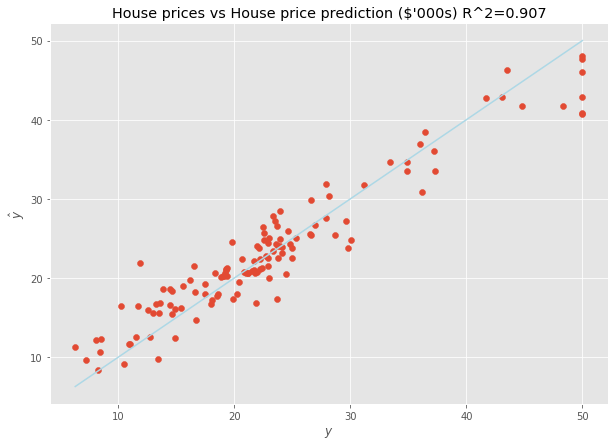

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

boston = datasets.load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
# Make predictions on unseen data
y_hat = fitted_model.predict(X_test)
print(y_hat)

r2 = r2_score(y_test, y_hat)
print(r2)

plt.style.use('ggplot')
plt.figure(figsize=(10, 7))
plt.scatter(y_test, y_hat)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='lightblue')
plt.xlabel(r"$y$")
plt.ylabel(r"$\hat{y}$")
plt.title(r"House prices vs House price prediction ($'000s) R^2={}".format(round(r2, 3)))
plt.show()

In [0]:
from sklearn.externals import joblib
model_path = 'house_price_regressor.pkl'
joblib.dump(fitted_model, model_path)

['house_price_regressor.pkl']

In [0]:
description = 'AutoML Model'
tags = None
model = remote_run.register_model(description = description, tags = tags)

print(remote_run.model_id) # This will be written to the script file later in the notebook.
print(model.name, model.id, model.version, sep = '\n')

[16:57:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Registering model AutoMLd3189333ebest
AutoMLd3189333ebest
AutoMLd3189333ebest
AutoMLd3189333ebest:1
1


In [0]:
%%writefile score.py

import json
import numpy as np

from sklearn.externals import joblib
from azureml.core.model import Model
import azureml.train.automl

def init():
    global model
    model_path = Model.get_model_path('house_price_regression')
    model = joblib.load(model_path)

def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    y_hat = model.predict(data)
    return y_hat.tolist()

Overwriting score.py


In [0]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies()
myenv.add_pip_package("numpy")
myenv.add_pip_package("azureml-sdk[notebooks]")
myenv.add_pip_package("azureml-sdk[automl]")
myenv.add_conda_package("scikit-learn")
env_path = 'my_env.yml'

with open(env_path,"w") as f:
    f.write(myenv.serialize_to_string())

In [0]:
from azureml.core.webservice import AksWebservice, Webservice
from azureml.core.model import Model
from azureml.core.compute import AksCompute, ComputeTarget

aks_target = AksCompute(ws,"myaks")
# If deploying to a cluster configured for dev/test, ensure that it was created with enough
# cores and memory to handle this deployment configuration. Note that memory is also used by
# things such as dependencies and AML components.
deployment_config = AksWebservice.deploy_configuration(cpu_cores = 1, memory_gb = 1)

from azureml.core.model import InferenceConfig

inference_config = InferenceConfig(runtime= "python", 
                                   entry_script="score.py",
                                   conda_file=env_path)

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={"data": "Boston House Prices",  "method" : "sklearn"}, 
                                               description='Predict House Prices using Ensemble Model')

service = Model.deploy(ws, "myservice", [model], inference_config, aciconfig, aks_target)
service.wait_for_deployment(show_output = True)
print(service.state)
print(service.get_logs())

ComputeTargetException: ComputeTargetException:
	Message: ComputeTargetNotFound: Compute Target with name myaks not found in provided workspace
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "ComputeTargetNotFound: Compute Target with name myaks not found in provided workspace"
    }
}

In [0]:
from azureml.core.webservice import AciWebservice
from azureml.core.webservice import Webservice
from azureml.core.image import ContainerImage
from azureml.core.model import Model
#score_path = 'score.py'

#image_config = ContainerImage.image_configuration(execution_script=score_path, 
                                                  #runtime="python", 
                                                  #conda_file=env_path)

from azureml.core.model import InferenceConfig

inference_config = InferenceConfig(runtime= "python", 
                                   entry_script="score.py",
                                   conda_file=env_path)

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={"data": "Boston House Prices",  "method" : "sklearn"}, 
                                               description='Predict House Prices using Ensemble Model')

from azureml.core.compute import AksCompute, ComputeTarget

# Use the default configuration (you can also provide parameters to customize this).
# For example, to create a dev/test cluster, use:
# prov_config = AksCompute.provisioning_configuration(cluster_purpose = AksCompute.ClusterPurpose.DEV_TEST)
prov_config = AksCompute.provisioning_configuration()

aks_name = 'myaks'
# Create the cluster
aks_target = ComputeTarget.create(workspace = ws,
                                    name = aks_name,
                                    provisioning_configuration = prov_config)

# Wait for the create process to complete
aks_target.wait_for_completion(show_output = True)

service = Model.deploy(workspace=ws,
                        name='automl-model-4',
                        deployment_config=aciconfig,
                        models=[model],
                        inference_config=inference_config,
                        aks_target = aks_target)

service.wait_for_deployment(show_output=True)

Creating.......................................................

In [0]:
from azureml.core.webservice import AciWebservice
from azureml.core.webservice import Webservice
from azureml.core.image import ContainerImage

score_path = 'score.py'

image_config = ContainerImage.image_configuration(execution_script=score_path, 
                                                  runtime="python", 
                                                  conda_file=env_path)

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=8, 
                                               tags={"data": "Boston House Prices",  "method" : "sklearn"}, 
                                               description='Predict House Prices using Ensemble Model')

service = Webservice.deploy_from_model(workspace=ws,
                                       name='automl-model-new1',
                                       deployment_config=aciconfig,
                                       models=[model],
                                       image_config=image_config)

service.wait_for_deployment(show_output=True)

Creating image
Running.............................................
Succeeded
Image creation operation finished for image automl-model-new1:1, operation "Succeeded"
Creating service
Running..............

In [0]:
from azureml.core.webservice import AciWebservice
from azureml.core.webservice import Webservice
from azureml.core.image import ContainerImage

score_path = 'score.py'

image_config = ContainerImage.image_configuration(execution_script=score_path, 
                                                  runtime="python", 
                                                  conda_file=env_path)

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=2, 
                                               tags={"data": "Boston House Prices",  "method" : "sklearn"}, 
                                               description='Predict House Prices using Ensemble Model')

In [0]:
from azureml.core.webservice import LocalWebservice, Webservice
from azureml.core.model import Model
deployment_config = LocalWebservice.deploy_configuration(port=8890)
deployment_config

service_name = 'myservice'
# Retrieve existing service.
service = Webservice(name=service_name, workspace=ws)

#service = Model.deploy(ws, "myservice", [model], inference_config = image_config, deployment_config = aciconfig)
service.wait_for_deployment(show_output = True)
print(service.state)

WebserviceException: WebserviceException:
	Message: WebserviceNotFound: Webservice with name myservice not found in provided workspace
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "WebserviceNotFound: Webservice with name myservice not found in provided workspace"
    }
}

In [0]:
print(service.scoring_uri)

In [0]:
service.get_logs()

'2019-09-09T11:07:40,977096480+00:00 - iot-server/run \n2019-09-09T11:07:40,982347412+00:00 - rsyslog/run \n2019-09-09T11:07:40,989084552+00:00 - gunicorn/run \n2019-09-09T11:07:40,990372460+00:00 - nginx/run \nEdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...\n2019-09-09T11:07:41,283737737+00:00 - iot-server/finish 1 0\n2019-09-09T11:07:41,290280277+00:00 - Exit code 1 is normal. Not restarting iot-server.\nStarting gunicorn 19.9.0\nListening at: http://127.0.0.1:31311 (11)\nUsing worker: sync\nworker timeout is set to 300\nBooting worker with pid: 45\n\'pattern\' package not found; tag filters are not available for English\nInitializing logger\nStarting up app insights client\nStarting up request id generator\nStarting up app insight hooks\nInvoking user\'s init function\n2019-09-09 11:07:49,021 | azureml.core.run | DEBUG | Could not load run context RunEnvironmentException:\n\tMessage: Could not load a submitted run, if outside of an execution context, use e